### Sample program for Ada Boost Classifier  

#### Import libraries  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from joblib import dump

#### Parameters  

In [2]:
csv_in = '../ai-11/titanic.csv'

#### Read CSV file  

PassengerID: 乗客ID  
Survived: (1:survived, 2:dead)  生存結果 (1: 生存, 2: 死亡)  
Pclass: class (grade) of passenger (1: highest)  乗客の階級 1が最高級  
Name: 乗客の名前  
Sex: 性別  
Age: 年齢  
SibSp: #brothers/sisters + #spouse 一緒に乗船していた兄弟＋配偶者の数  
Parch: #parents + #children 一緒に乗船していた両親＋子供の数  
Ticket: チケット番号  
Fare: 乗船料金  
Cabin:  Cabin ID  部屋番号  
Embarked: (Cherbourg、Queenstown、Southampton) name of embarked port 乗船した港名  

In [3]:
df = pd.read_csv(csv_in, delimiter=',', skiprows=0, header=0)
print(df.shape)
print(df.info())
display(df.head())

(891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Drop rows with missing value at Age and Embarked column  

In [4]:
df = df.dropna(subset=['Age','Embarked']).reset_index(drop=True)

#### Extract data  

In [5]:
X= df[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
X = pd.get_dummies(X, drop_first=True)
y = df['Survived']

In [6]:
print(X.shape)
print(X.info())
display(X.head())
print(y.shape)
print(y.head())

(712, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      712 non-null    int64  
 1   Age         712 non-null    float64
 2   SibSp       712 non-null    int64  
 3   Parch       712 non-null    int64  
 4   Fare        712 non-null    float64
 5   Sex_male    712 non-null    uint8  
 6   Embarked_Q  712 non-null    uint8  
 7   Embarked_S  712 non-null    uint8  
dtypes: float64(2), int64(3), uint8(3)
memory usage: 30.0 KB
None


,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,1,0,1
1,1,38.0,1,0,71.2833,0,0,0
2,3,26.0,0,0,7.9250,0,0,1
3,1,35.0,1,0,53.1000,0,0,1
4,3,35.0,0,0,8.0500,1,0,1


(712,)
0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64


#### Make pipeline and set parameters for grid search 

In [7]:
gbc=GradientBoostingClassifier(random_state=0)            

# Hyperparameter settings for grid search
param_grid = {
    'n_estimators': [50, 100, 500],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth' : [2, 4, 6],
}

#### Preparation of objects for cross validation  

In [8]:
grid_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=7)
gen_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=11)

#### Define the grid search for hyperparameters  

In [9]:
gs = GridSearchCV(gbc, param_grid , cv=grid_cv, scoring='accuracy')

#### Estimation of generalization performance  

In [10]:
%%time
nested_score = cross_val_score(gs, X=X, y=y, cv=gen_cv,
                               scoring='accuracy')
print(nested_score)
print(nested_score.mean())

[0.76404494 0.76404494 0.8258427  0.74719101]
0.7752808988764045
CPU times: user 1min 9s, sys: 9.31 ms, total: 1min 10s
Wall time: 1min 10s


**Generalization performance (ave accuracy) / 汎化性能 (平均accuracy): 0.775**  

#### Cross-validation to obtain the model with the best hyperparameter set (best estimator)  
- Note: gs_best is already fit to the whole data (X) in gs.fit(X, y)  

In [11]:
%%time
gs.fit(X, y)
gs_best = gs.best_estimator_

CPU times: user 20 s, sys: 0 ns, total: 20 s
Wall time: 20 s


In [12]:
print(gs_best)

GradientBoostingClassifier(learning_rate=0.01, max_depth=4, n_estimators=500,
                           random_state=0)


**Optimal hyperparameters / 最適なハイパーパラメータ: max_depth=4, learning_rate=0.01, n_estimators=500**  

#### Show feature importances of the best model  

In [13]:
print(pd.Series(gs_best.feature_importances_, index=X.columns))

Pclass        0.177174
Age           0.173148
SibSp         0.065564
Parch         0.011317
Fare          0.141229
Sex_male      0.427189
Embarked_Q    0.000000
Embarked_S    0.004379
dtype: float64


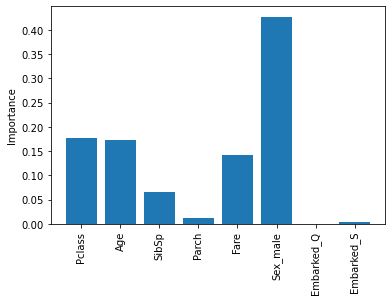

In [14]:
plt.bar(X.columns, gs_best.feature_importances_)
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

#### Save the trained model  

In [15]:
tag = 'titanic'
model_file = 'gbc_best_{}.joblib'.format(tag)
dump(gs_best, model_file)

['gbc_best_titanic.joblib']